In [1]:
import pints
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters
times = np.linspace(0, 1000, 400)

In [3]:
# Simulate time series
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)
noise = 0.05 * range_values
values = org_values + np.random.normal(0, noise, org_values.shape)

model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Train emulator
input_parameters = log_prior.sample(2000)
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)

# Flatten likelihood function to avoid overestimating gradients
likelihoods = np.array([0.7*l for l in likelihoods])

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
log_posterior_emu = pints.LogPosterior(emu, log_prior)

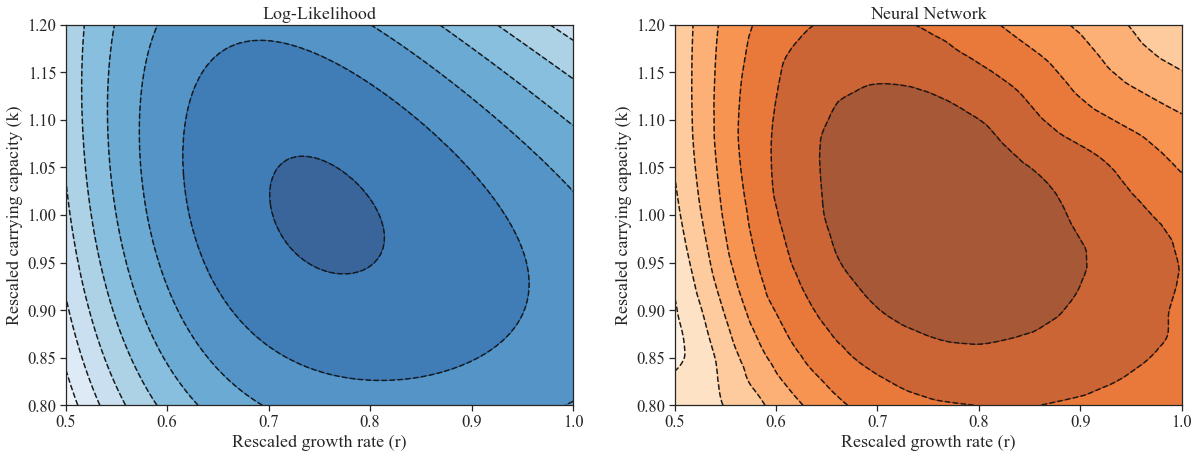

In [4]:
sns.set(context='notebook', style='ticks', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

# Create grid of parameters
xmin, xmax = 0.5, 1.0
ymin, ymax = 0.8, 1.2
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.set_xlabel('Rescaled growth rate (r)')
ax1.set_ylabel('Rescaled carrying capacity (k)')
ax2.set_xlabel('Rescaled growth rate (r)')
ax2.set_ylabel('Rescaled carrying capacity (k)')

ax1.contourf(xx, yy, ll, cmap='Blues', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Oranges', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

fig.savefig("figures/gradients-flattened/contours.png", bbox_inches='tight', dpi=200)

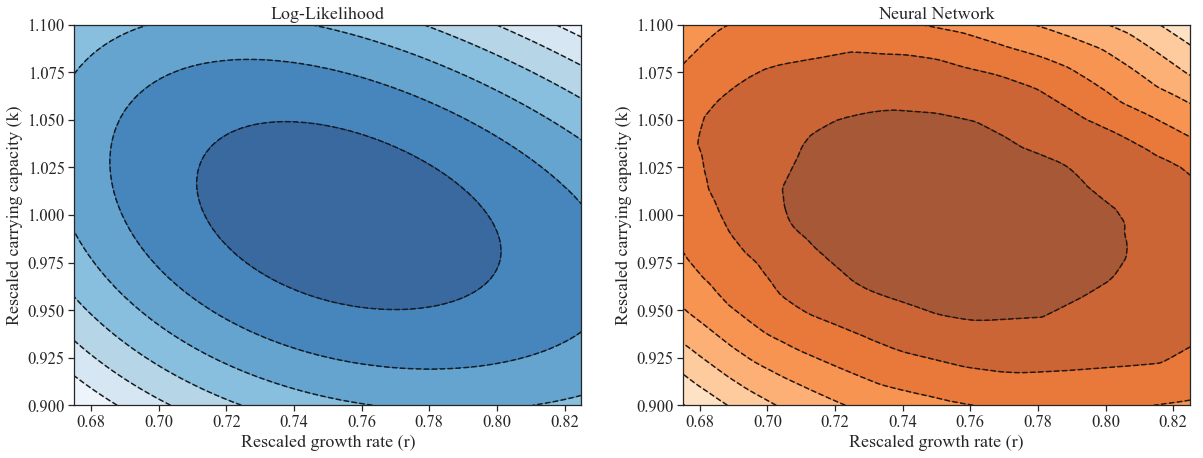

In [5]:
# Create grid of parameters
xmin, xmax = 0.675, 0.825
ymin, ymax = 0.9, 1.1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.set_xlabel('Rescaled growth rate (r)')
ax1.set_ylabel('Rescaled carrying capacity (k)')
ax2.set_xlabel('Rescaled growth rate (r)')
ax2.set_ylabel('Rescaled carrying capacity (k)')

ax1.contourf(xx, yy, ll, cmap='Blues', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Oranges', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

fig.savefig("figures/gradients-flattened/contours-closer.png", bbox_inches='tight', dpi=200)

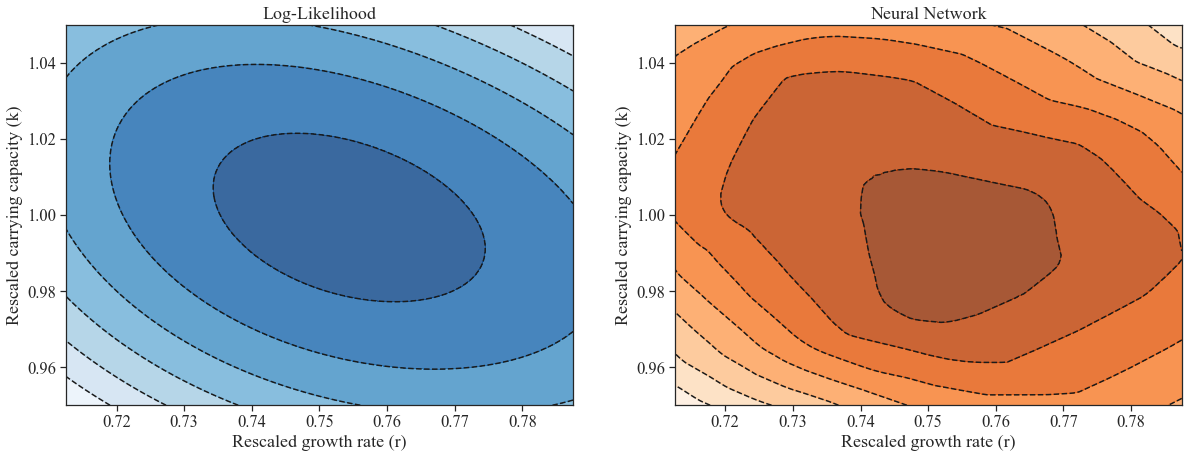

In [6]:
# Create grid of parameters
xmin, xmax = 0.7125, 0.7875
ymin, ymax = 0.95, 1.05
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.set_xlabel('Rescaled growth rate (r)')
ax1.set_ylabel('Rescaled carrying capacity (k)')
ax2.set_xlabel('Rescaled growth rate (r)')
ax2.set_ylabel('Rescaled carrying capacity (k)')

ax1.contourf(xx, yy, ll, cmap='Blues', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Oranges', alpha=0.8, extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

fig.savefig("figures/gradients-flattened/contours-closest.png", bbox_inches='tight', dpi=200)

In [7]:
n_iterations = 1000
factor = 0.9
x0 = np.array(start_parameters) * factor
sigma0 = np.array(start_parameters) * 5e-05

In [8]:
xs = []
diffs = []
orig_rule = []
first_rule = []
second_rule = []
step1 = [0] * n_iterations
step2 = [0] * n_iterations
alphas = []
orig = [0] * n_iterations
    
# Run MCMC methods 
for n in range(0, n_iterations):
    if n == 0:
        # Current point and proposed point
        current = x0
        current_log_pdf = log_posterior_emu(x0)
        true_current_log_pdf = log_posterior(x0)
        proposed = None

        # Acceptance rate and error monitoring
        error = 0
        accepted1 = 0
        accepted2 = 0
        orig_accepted = 0

        # Check initial position
        x0 = pints.vector(x0)

        # Get number of parameters
        n_parameters = len(x0)

        # Check initial standard deviation
        if sigma0 is None:
            # Get representative parameter value for each parameter
            sigma0 = np.abs(x0)
            sigma0[sigma0 == 0] = 1
            # Use to create diagonal matrix
            sigma0 = np.diag(0.01 * sigma0)
        else:
            sigma0 = np.array(sigma0)
            if np.product(sigma0.shape) == n_parameters:
                # Convert from 1d array
                sigma0 = sigma0.reshape((n_parameters,))
                sigma0 = np.diag(sigma0)
            else:
                # Check if 2d matrix of correct size
                sigma0 = sigma0.reshape((n_parameters, n_parameters))

    # Ask- Propose new point
    #if proposed is None:
    proposed = np.random.multivariate_normal(current, sigma0)

    # Tell    
    # Calculate logpdfs
    fx = log_posterior_emu(proposed)
    true_fx = log_posterior(proposed)
    error += np.abs((true_fx - fx) / true_fx)

    # Check if the proposed point can be accepted using the emulator
    if np.isfinite(fx):
        # Step 1 - Initial reject step:
        u1 = np.log(np.random.uniform(0, 1))
        alpha1 = min(0, (fx - current_log_pdf)[0][0]) # either alpha1 or alpha2 must be 0
        if alpha1 > u1:
            accepted1 += 1
            step1[n] = 1
            # Step 2 - Metropolis step:
            u2 = np.log(np.random.uniform(0, 1))
            alpha2 = min(0, (current_log_pdf - fx)[0][0])
            if ((true_fx + alpha2) - (true_current_log_pdf + alpha1)) > u2:
                accepted2 += 1 
                step2[n] = 1

    # Check if the proposed point can be accepted using standard MCMC
    if np.isfinite(fx):
        # Step 1 - Initial reject step:
        u = np.log(np.random.uniform(0, 1))
        alpha = true_fx - true_current_log_pdf
        if alpha > u:
            orig_accepted += 1
            orig[n] = 1

    # Clear proposal
    xs.append(proposed)
    proposed = None
    
    # Compute difference between emulator and true model
    diff = true_fx - fx
    diffs.append(diff[0][0])
    orig_rule.append(alpha)
    first_rule.append(alpha1)
    if step1[n] == 1:
        second_rule.append(((true_fx + alpha2) - (true_current_log_pdf + alpha1)))
        alphas.append(alpha2)
    else:
        second_rule.append(-200)
        alphas.append(0)


# Compute acceptance rates
mae = error[0][0] / n_iterations
acceptances = accepted2 / n_iterations
acceptances1 = accepted1 / n_iterations
acceptances2 = accepted2 / accepted1
orig_acceptances = orig_accepted / n_iterations


In [9]:
print("Overall:", acceptances)
print("1st-step:", acceptances1)
print("2nd-step:", acceptances2)
print("Original:", orig_acceptances)


Overall: 0.485
1st-step: 0.498
2nd-step: 0.9738955823293173
Original: 0.49


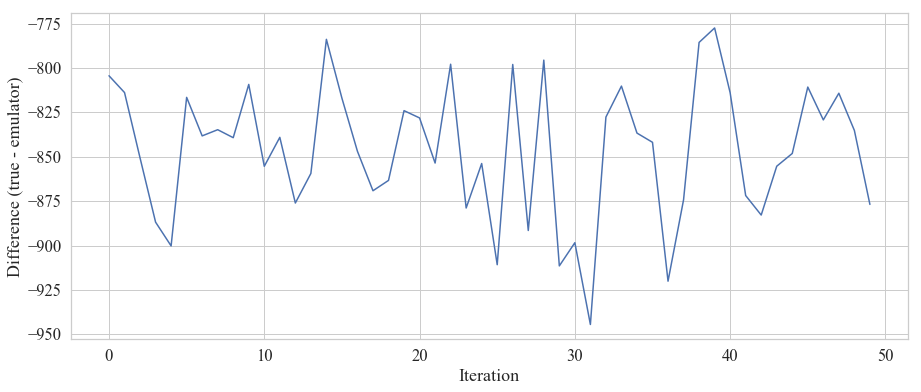

In [10]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Difference (true - emulator)')
ax.plot(diffs[:50])
plt.show()

fig.savefig("figures/gradients-flattened/differences-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [11]:
step_sum = [s1 + s2 for (s1, s2) in zip(step1, step2)]
step_sum1 = [s - 1 if s>0 else s for s in step_sum]
sum([s == o for (s, o) in zip(step_sum1, orig)][:50])

50

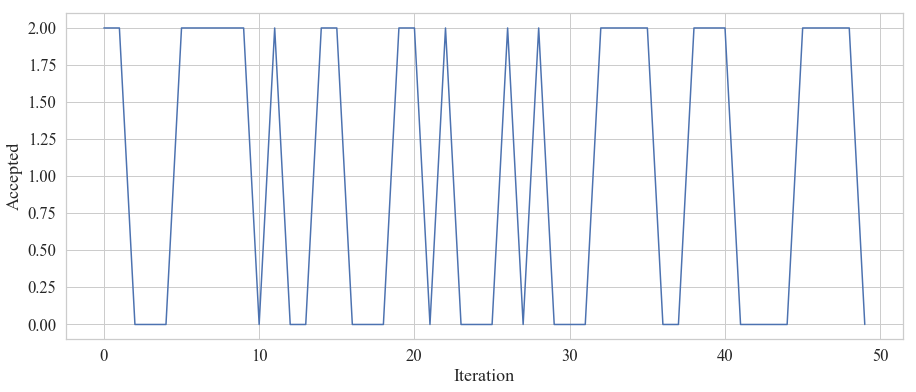

In [12]:
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Accepted')
ax.plot(step_sum[:50])
plt.show()

fig.savefig("figures/gradients-flattened/emulator-acceptance-"+str(factor)+".png", bbox_inches='tight', dpi=200)

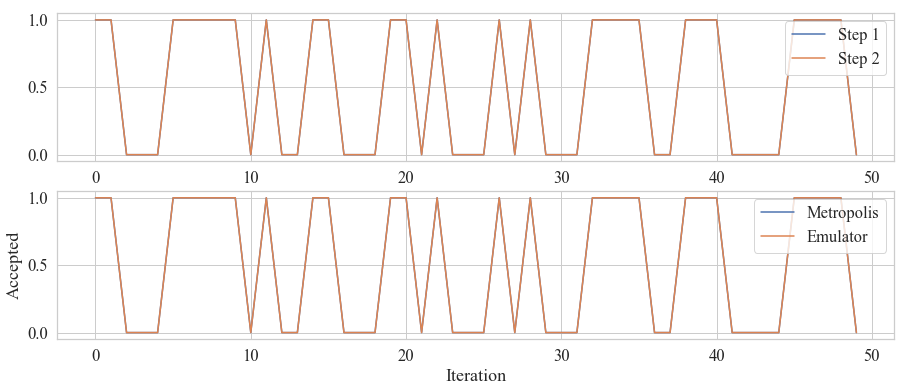

In [13]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Accepted')
ax1.plot(step1[:50], label='Step 1')
ax1.plot(step2[:50], label='Step 2')
ax1.legend()
ax2.plot(orig[:50], label='Metropolis')
ax2.plot(step_sum1[:50], label='Emulator')
plt.legend()
plt.show()

fig.savefig("figures/gradients-flattened/acceptances-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [14]:
step_sum = [s1 + s2 for (s1, s2) in zip(step1, step2)]
step_sum1 = [s - 1 if s>0 else s for s in step_sum]
sum([s == o for (s, o) in zip(step_sum1, orig)][:50])

50

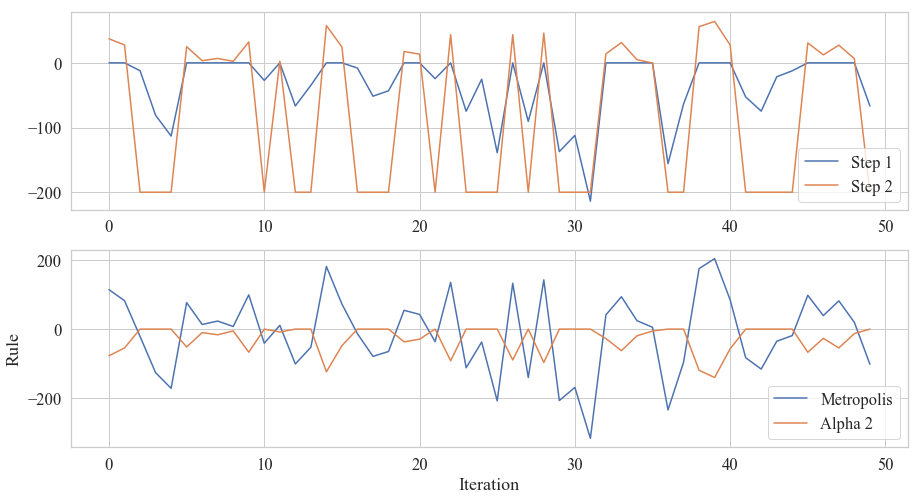

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8))
plt.xlabel('Iteration')
plt.ylabel('Rule')
ax1.plot(first_rule[:50], label='Step 1')
ax1.plot(second_rule[:50], label='Step 2')
ax1.legend()
ax2.plot(orig_rule[:50], label='Metropolis')
ax2.plot(alphas[:50], label='Alpha 2')
ax2.legend()
plt.show()

fig.savefig("figures/gradients-flattened/alphas-"+str(factor)+".png", bbox_inches='tight', dpi=200)

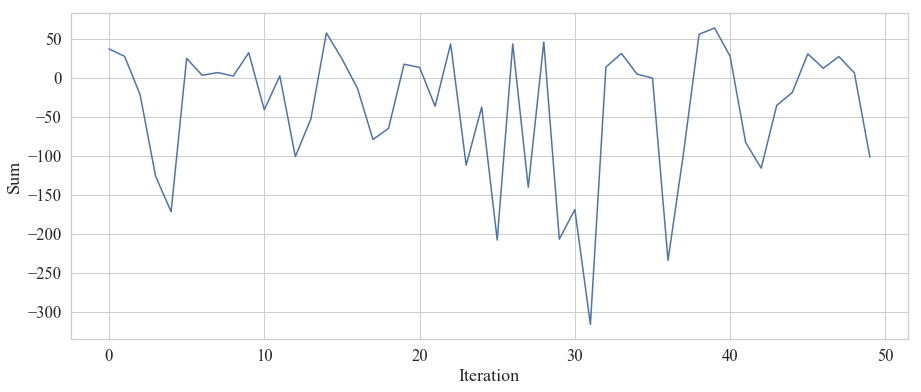

In [16]:
addition = [o + a for (o, a) in zip(orig_rule, alphas)]

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Sum')
ax.plot(addition[:50])
#ax.plot(second_rule[:50], label='Step 2')
plt.show()

fig.savefig("figures/gradients-flattened/step2-"+str(factor)+".png", bbox_inches='tight', dpi=200)

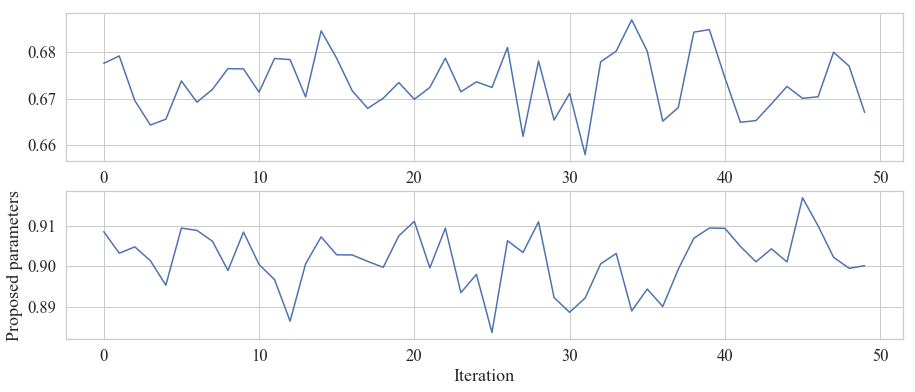

In [17]:
r = [x[0] for x in xs]
k = [x[1] for x in xs]
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Proposed parameters')
ax1.plot(r[:50])
ax2.plot(k[:50])
plt.show()

fig.savefig("figures/gradients-flattened/acceptances-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [18]:
factor = 1.15

In [19]:
delta = 0.005
x = np.array(start_parameters) * factor
r1 = x - [delta, 0.0]
r2 = x + [delta, 0.0]
k1 = x - [0.0, delta]
k2 = x + [0.0, delta]

emu_gradient_r = (emu(r2) - emu(r1)) / (2*delta)
emu_gradient_k = (emu(k2) - emu(k1)) / (2*delta)

gradient_r = (log_likelihood(r2) - log_likelihood(r1)) / (2*delta)
gradient_k = (log_likelihood(k2) - log_likelihood(k1)) / (2*delta)

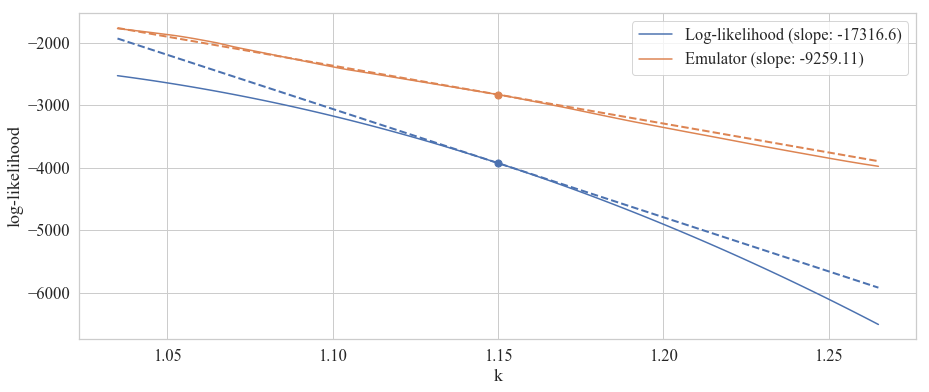

In [20]:
# fix one parameter to plot in 2D
r = x[0]
# take a range over the free parameter
ks = np.linspace(x[1]*0.9, x[1]*1.1, 100)
# create parameter pairs
pairs = [[r, k] for k in ks]
# compute likelihoods for pairs
emu_ls = [emu(p)[0][0] for p in pairs]
ls = [log_likelihood(p) for p in pairs]

# choose point to plot tangent line
k = x[1]
e = emu([r, k])[0][0]
l = log_likelihood([r, k])

# define tangent line as:
# y = m*(x - x1) + y1
def tangent(x, x1, y1, slope):
    return slope*(x - x1) + y1

# plot the log-likelihoods and tangents
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('k')
plt.ylabel('log-likelihood')
ax.plot(ks, ls, label="Log-likelihood (slope: "+str(round(gradient_k, 2))+")")
ax.scatter(k, l, color='C0', s=50)
ax.plot(ks, tangent(ks, k, l, gradient_k), 'C0--', linewidth = 2)
ax.plot(ks, emu_ls, label="Emulator (slope: "+str(round(emu_gradient_k[0][0], 2))+")")
ax.scatter(k, e, color='C1', s=50)
ax.plot(ks, tangent(ks, k, e, emu_gradient_k[0][0]), 'C1--', linewidth = 2)
plt.legend()
plt.show()

fig.savefig("figures/gradients-flattened/r"+str(r)+"fixed-k"+str(k)+".png", bbox_inches='tight', dpi=200)

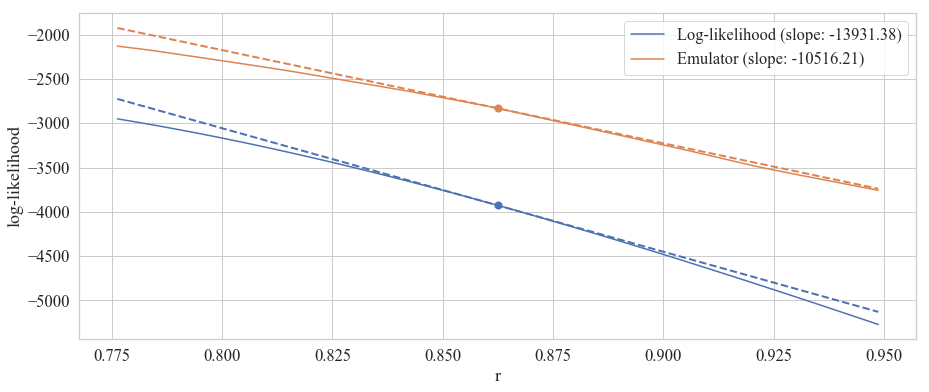

In [21]:
# fix one parameter to plot in 2D
k = x[1]
# take a range over the free parameter
rs = np.linspace(x[0]*0.9, x[0]*1.1, 100)
# create parameter pairs
pairs = [[r, k] for r in rs]
# compute likelihoods for pairs
emu_ls = [emu(p)[0][0] for p in pairs]
ls = [log_likelihood(p) for p in pairs]

# choose point to plot tangent line
r = x[0]
e = emu([r, k])[0][0]
l = log_likelihood([r, k])

# define tangent line as:
# y = m*(x - x1) + y1
def tangent(x, x1, y1, slope):
    return slope*(x - x1) + y1

# plot the log-likelihoods and tangents
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('r')
plt.ylabel('log-likelihood')
ax.plot(rs, ls, label="Log-likelihood (slope: "+str(round(gradient_r, 2))+")")
ax.scatter(r, l, color='C0', s=50)
ax.plot(rs, tangent(rs, r, l, gradient_r), 'C0--', linewidth = 2)
ax.plot(rs, emu_ls, label="Emulator (slope: "+str(round(emu_gradient_r[0][0], 2))+")")
ax.scatter(r, e, color='C1', s=50)
ax.plot(rs, tangent(rs, r, e, emu_gradient_r[0][0]), 'C1--', linewidth = 2)
plt.legend()
plt.show()

fig.savefig("figures/gradients-flattened/r"+str(r)+"-k"+str(k)+"fixed.png", bbox_inches='tight', dpi=200)

In [22]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [23]:
import time

n_chains = 3
n_iter = 30000 # Add stopping criterion
warm_up = 10000
sigma0 = np.abs(start_parameters) * 5e-05 # Choose a covariance matrix for the proposal step
x0 = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]
scaling_factors = [1/50, 500]
param_names=["r", "k"]

In [24]:
## Running MCMC routines

### Standard Metropolis Hastings MCMC

Running...
Done!
R-hat:
[1.000245831213257, 1.0001380387147432]


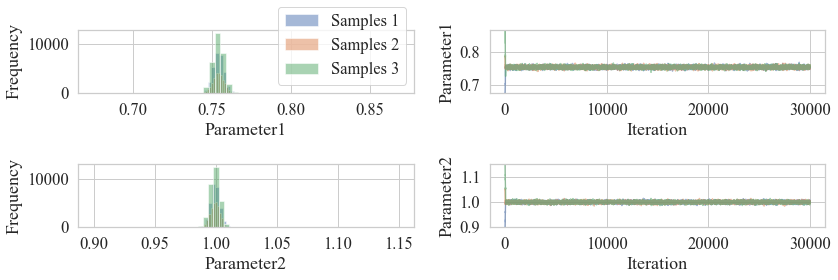

In [25]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, n_chains, x0, sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
metropolis_chains = mcmc.run()
end = time.time()
print('Done!')

metropolis_diff = end - start
metropolis_rates = mcmc.acceptance_rates()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains[:, warm_up:, :]))

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(metropolis_chains[:, warm_up:, :][0])

# Show graphs
plt.show()

In [26]:
print("Acceptance rates:", metropolis_rates)
print("Running time    :", metropolis_diff)

Acceptance rates: [0.29906666666666776, 0.29780000000000134, 0.30130000000000157]
Running time    : 20.358309030532837


In [27]:
metropolis_results = pints.MCMCSummary(chains=metropolis_chains[:, warm_up:, :], 
                                       time=metropolis_diff, parameter_names=param_names)
# Revert scaling
metropolis_chains_rescaled = np.copy(metropolis_chains)
metropolis_chain_rescaled = metropolis_chains_rescaled[0]
metropolis_chain_rescaled = metropolis_chain_rescaled[warm_up:] # Discard warm up
metropolis_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                              for chain in metropolis_chains])
metropolis_chain = metropolis_chains[0]
metropolis_chain = metropolis_chain[warm_up:]

metropolis_results.save('figures/nn-6-64-10000.xlsx', 'metropolis')

,mean,std.,2.5%,25%,50%,75%,97.5%,rhat,ess,ess per sec.,time
param,,,,,,,,,,,
r,0.753941,0.003416,0.747194,0.751664,0.753969,0.756185,0.760720,1.000246,5343.198977,262.457897,20.358309
k,0.999372,0.003762,0.991877,0.996883,0.999415,1.001899,1.006691,1.000138,5811.135099,285.442916,20.358309


In [28]:
### Metropolis Hastings MCMC using NN as posterior


Running...
Done!
R-hat:
[1.0001406654963416, 1.000174643905061]


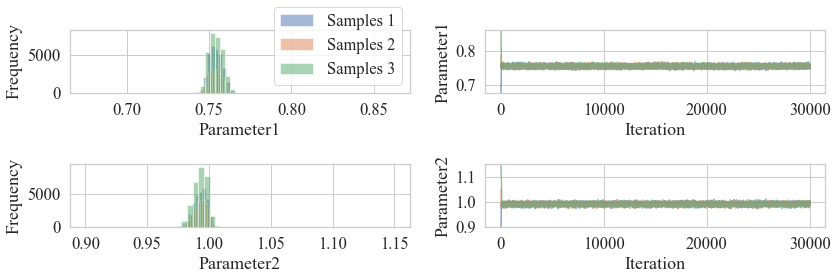

In [29]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0, sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
chains_emu = mcmc.run()
end = time.time()
print('Done!')

nn_diff = end - start
nn_rates = mcmc.acceptance_rates()

# Discard warm up
chains_emu_thinned = chains_emu[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thinned))

# Show traces and histograms
pints.plot.trace(chains_emu)

# Look at distribution in chain 0
#pints.plot.pairwise(chains_emu_thinned[0])

# Show graphs
plt.show()

In [30]:
print("Acceptance rates:", nn_rates)
print("Running time    :", nn_diff)

Acceptance rates: [0.3961333333333328, 0.3966666666666661, 0.39846666666666686]
Running time    : 64.03081750869751


In [31]:
nn_results = pints.MCMCSummary(chains=chains_emu[:, warm_up:, :], time=nn_diff,
                            parameter_names=param_names)

# Revert scaling
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[warm_up:]
chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])
chain_emu = chains_emu[0]
chain_emu = chain_emu[warm_up:]

nn_results.save('figures/nn-6-64-10000.xlsx', 'nn')

,mean,std.,2.5%,25%,50%,75%,97.5%,rhat,ess,ess per sec.,time
param,,,,,,,,,,,
r,0.754057,0.004093,0.746856,0.750913,0.753872,0.757053,0.762092,1.000141,5808.231042,90.709931,64.030818
k,0.992753,0.005622,0.980685,0.988988,0.993255,0.996956,1.002214,1.000175,4739.679816,74.021854,64.030818


In [32]:
### 2-Step MCMC using NN as emulator

Running...
Done!
R-hat:
[1.0011355733977205, 1.002469105547468]


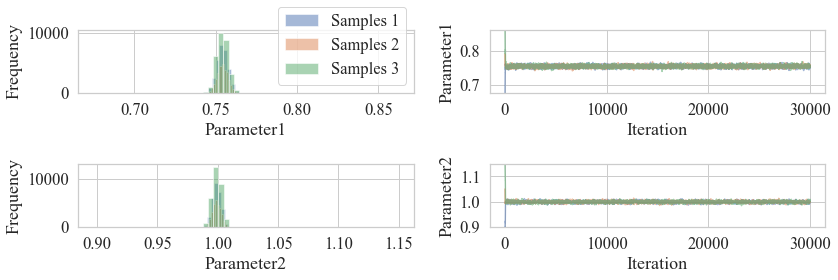

In [33]:
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, n_chains, x0, sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(n_iter)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
start = time.time()
emulated_chains = mcmc.run()
end = time.time()
print('Done!')

emulated_diff = end - start
emulated_rates = mcmc.acceptance_rates()

# Discard warm up
emulated_chains_thinned = emulated_chains[:, warm_up:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Look at distribution in chain 0
#pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [34]:
print("Acceptance rates:\n", emulated_rates)
print("Running time    :", emulated_diff)

Acceptance rates:
 [(0.19253333333333406, 0.42330000000000073, 0.454838963697929), (0.19029999999999964, 0.41946666666666665, 0.45367132867132864), (0.1954333333333333, 0.4273666666666667, 0.4572966227283363)]
Running time    : 87.06514596939087


In [35]:
emulated_results = pints.MCMCSummary(chains=emulated_chains[:, warm_up:, :], time=emulated_diff,
                            parameter_names=param_names)

# Revert scaling
emulated_chains_rescaled = np.copy(emulated_chains)
emulated_chain_rescaled = emulated_chains_rescaled[0]
emulated_chain_rescaled = emulated_chain_rescaled[warm_up:]
emulated_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                            for chain in emulated_chains])
emulated_chain = emulated_chains[0]
emulated_chain = emulated_chain[warm_up:]

emulated_results.save('figures/nn-6-64-10000.xlsx', '2-steps')

,mean,std.,2.5%,25%,50%,75%,97.5%,rhat,ess,ess per sec.,time
param,,,,,,,,,,,
r,0.754029,0.003349,0.747637,0.751776,0.754023,0.75628,0.760619,1.001136,2806.735575,32.237189,87.065146
k,0.999232,0.003693,0.991867,0.996809,0.999237,1.00180,1.006380,1.002469,2074.183823,23.823354,87.065146


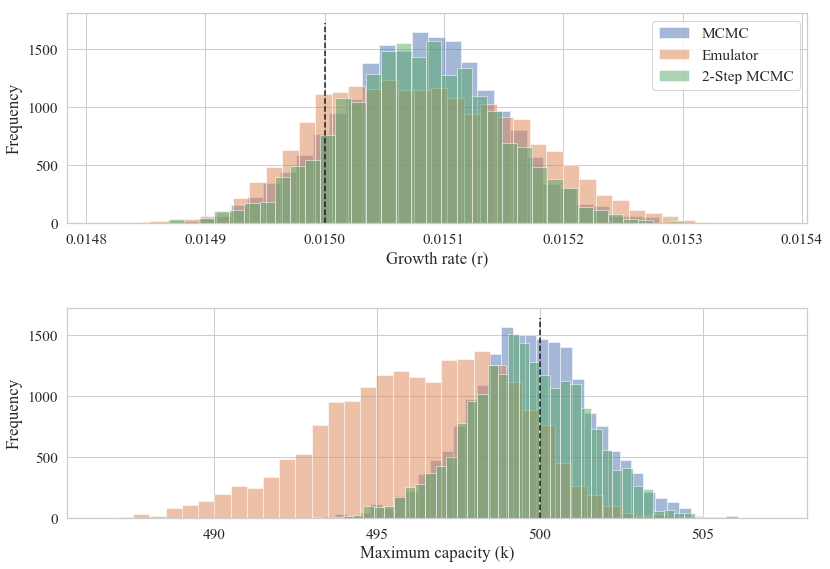

In [36]:
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.4, color_codes=True, rc={"grid.linewidth": 1})

fig, axes = pints.plot.histogram([metropolis_chain, chain_emu, emulated_chain], 
                                ref_parameters=true_parameters, 
                                sample_names=["MCMC", "Emulator", "2-Step MCMC"],
                                parameter_names=["Growth rate (r)", "Maximum capacity (k)"])
#axes[0].set_title('Comparison of log-posterior sample distributions\n', fontsize=16)
fig.set_size_inches(14, 10)
plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()
#fig.savefig("figures/gradients/log-posterior-samples-nn-6-64.png", bbox_inches='tight', dpi=600)

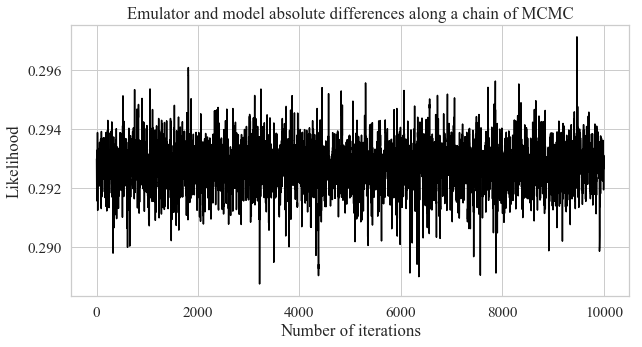

0.29266498523348244

In [37]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, metropolis_chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

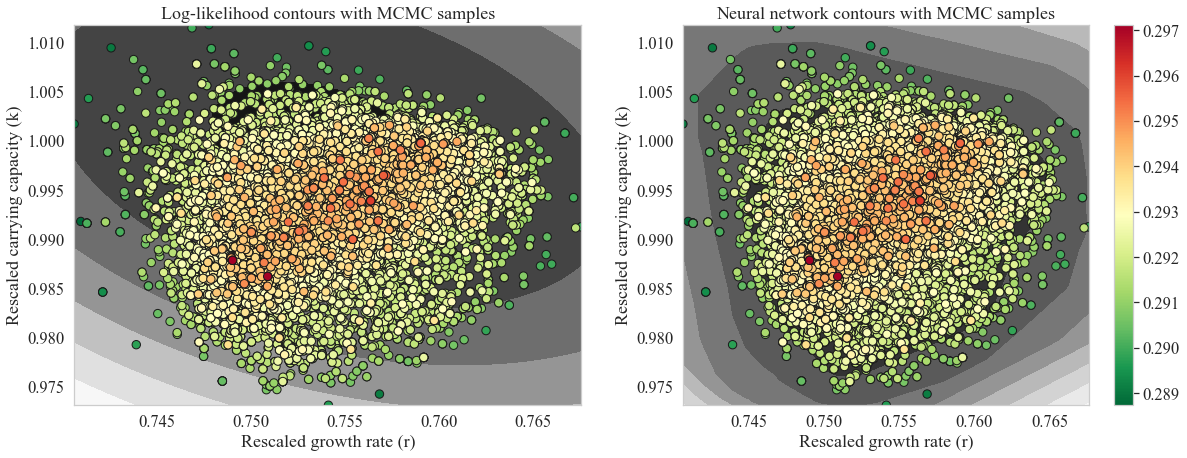

In [38]:
sns.set(context='notebook', style='whitegrid', palette="deep", font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-likelihood contours with MCMC samples')
ax2.title.set_text('Neural network contours with MCMC samples') 
ax1.set_xlabel('Rescaled growth rate (r)')
ax1.set_ylabel('Rescaled carrying capacity (k)')
ax2.set_xlabel('Rescaled growth rate (r)')
ax2.set_ylabel('Rescaled carrying capacity (k)')

# Create grid of parameters
x = [p[0] for p in chain_emu_rescaled]
y = [p[1] for p in chain_emu_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
#ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
#ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

#fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()
#fig.savefig("figures/errors-on-contours-nn-6-64.png", bbox_inches='tight', dpi=600)